In [1]:
!pip install face_recognition
!pip install -Uqq fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=198c261be9b117f74edaccba75df205fa3c9765dc3de474a249e42781d7c3533
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
     |████████████████████████████████| 719 kB 9.4 MB/s 
     |████████████████████████████████| 346 kB 61.1 MB/s 
     |████████████████████████████████| 197 kB 78.3 MB/s 
     |████████████████████████████████| 1.2 MB 57.9 MB/s 
     |████████████████████████████████| 4.2 MB 57.0 MB/s 
     |████████████████████████████████| 60 kB 8.8 MB/s 
     |████████████████████████████████| 140 kB 73.6 MB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
     |████████████████████████████████| 

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
!rm -rf data/
!gdown --id 17UpPnLJrIkMIrfNkgdPt0QJwruoGF03s #video test file
!gdown --id 17A7V2c4xm8nYJFqG9MeNTU8M_YBEt3W9 #video file (for dataset)
!gdown --id 1vNkspg4JwQXcQHG9oWQG3Fi8PfW5YDuD #align.json output from gentle forced aligner
!gdown --id 1N1GDtYjj3_vdRTp6m310qj6p6f2HlwqK # cropped dataset
!mkdir data/

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17UpPnLJrIkMIrfNkgdPt0QJwruoGF03s
To: /content/videopreview.mp4
100% 477k/477k [00:00<00:00, 138MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17A7V2c4xm8nYJFqG9MeNTU8M_YBEt3W9
To: /content/video.mp4
100% 328M/328M [00:01<00:00, 229MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https:

In [ ]:
import numpy as np
import pandas as pd
import json
import cv2
from IPython.display import HTML, display
import time
import os.path as op
from glob import glob

In [ ]:
import face_recognition # no need

In [ ]:
def progress(now, max):
    return HTML("""
        <text> {run} </text>
    """.format(run=str(now)+'/'+str(max)))

# Dataset

**Open and crop video file.**

In [ ]:
cap = cv2.VideoCapture('video.mp4')
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
  fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
else :
  fps = cap.get(cv2.CAP_PROP_FPS)

frame_count = int(cap. get(cv2. CAP_PROP_FRAME_COUNT))
print("Frames: " + str(frame_count))
print("Frames per second: " + str(fps))
print("lenght: " + str(frame_count/fps))
cap.release()

Frames: 131664
Frames per second: 29.97002997002997
lenght: 4393.1888



Cropping process
```
import face_recognition

#No mouth crop
out = display(progress(0, 100), display_id=True)

data = []

run = 0
while True:
  _, frame = cap.read()
  if frame is None:
    break
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  run+=1
  out.update(progress(run, frame_count))
  num = str(run)
  for _ in range(len(str(frame_count))-len(num)):
    num = '0'+num
  if not exists(f'data/{num}.jpg'):
    cv2.imwrite(f'data/{num}.jpg', frame)

cap.release()
```
Took really long

```
# first run 70,000
# second chunk 50,000
# last: the rest
chunk = 131664
out = display(progress(0, 100), display_id=True)
for i in range(120000, 131664):
  num = str(i+1)
  for _ in range(len(str(frame_count))-len(num)):
    num = '0'+ num
  frame = cv2.imread(f"data/{num}.jpg")
  face_landmarks_list = face_recognition.face_landmarks(frame)
  if face_landmarks_list != []:
    [x, y, w, h] = crop(face_landmarks_list[0]['top_lip'] + face_landmarks_list[0]['bottom_lip'])
    frame = frame[y:h, x:w]
  cv2.imwrite(f"cropped/{num}.jpg", frame)
  out.update(progress(i+1, chunk))
```





In [ ]:
#aligner
align = json.load(open("align.json"))['words']
aligned = []
for _d in range(len(align)):
  d = align[_d]
  if d["case"] == "success":
    if _d > 0 and align[_d-1]["case"] == "success" and d["start"] - align[_d-1]["end"] != 0:
      aligned.append({"duration":d["start"] - align[_d-1]["end"],"phone":"none","start":align[_d-1]["end"],"end":d["start"],"case":"success"})
    phones = d["phones"]
    for p in range(len(phones)):
      if p == 0:
        phones[p]["start"] = d["start"]
        phones[p]["end"] = phones[p]["start"] + phones[p]["duration"]
      else:
        phones[p]["start"] = phones[p-1]["end"]
        phones[p]["end"] = phones[p]["start"] + phones[p]["duration"]
      phones[p]["case"] = "success"
      phones[p]["phone"] = phones[p]["phone"].split("_")[0] #not sure about this
      phones[p]["duration"] = phones[p]["end"] - phones[p]["start"]
      if phones[p]["phone"] == "oov":
        phones[p]["case"] = "failed"
        phones[p]["phone"] = "none"
    for i in phones:
      aligned.append(i)
  elif align[_d]["case"] != "success" and align[_d-1]["case"] == "success" and _d != 0:
    index = _d
    while True:
      index += 1
      if align[index]["case"] == "success":
        aligned.append({"duration":align[index]["start"] - align[_d-1]["end"],"phone":"none","start":align[_d-1]["end"],"end":align[index]["start"],"case":"failed"})
        break
  elif align[_d]["case"] != "success" and _d == 0:      
    index = _d
    while True:
      index += 1
      if align[index]["case"] == "success":
        aligned.append({"duration":align[index]["start"],"phone":"none","start":0,"end":align[index]["start"],"case":"failed"})
        break

pd.DataFrame(aligned)

FileNotFoundError: ignored

In [ ]:
!gdown --id 1Y2dv54GeKnkJ09AJIsNIuW_XF54-b2GI

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y2dv54GeKnkJ09AJIsNIuW_XF54-b2GI
To: /content/data.csv
100% 3.86M/3.86M [00:00<00:00, 271MB/s]


In [ ]:
#This takes quite long ↑ download ↑

frame_phone = []
out = display(progress(0, 100), display_id=True)
for i in range(frame_count):
  now = {}
  num = str(i+1)
  for _ in range(len(str(frame_count))-len(num)):
    num = '0'+ num
  num = num + '.jpg'
  time = (i+1)/fps
  for a in aligned:
    if a["start"] <= time and a["end"] > time:
      now["image"] = num
      now["phone"] = a["phone"]
      now["case"] = a["case"]
  frame_phone.append(now)
  out.update(progress(i+1, frame_count))

df = pd.DataFrame(frame_phone)
df.to_csv('data.csv')
df

,image,phone,case
0,000001.jpg,none,failed
1,000002.jpg,none,failed
2,000003.jpg,none,failed
3,000004.jpg,none,failed
4,000005.jpg,none,failed
...,...,...,...
131659,NaN,NaN,NaN
131660,NaN,NaN,NaN
131661,NaN,NaN,NaN
131662,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("data.csv")
df.phone.value_counts()

none    38193
t        5925
iy       5922
ah       5921
n        5205
ih       4768
s        4576
ay       4066
l        3866
r        3437
ow       3131
z        2992
k        2963
ae       2690
m        2569
d        2541
uw       2469
eh       2345
w        2320
er       2264
ey       2152
hh       1926
b        1917
ao       1744
aa       1676
ng       1620
y        1614
aw       1576
f        1491
dh       1472
p        1460
v        1242
g         852
th        580
uh        528
sh        528
jh        517
ch        344
oy        238
zh         24
Name: phone, dtype: int64

In [ ]:
df[100:150]

,Unnamed: 0,image,phone,case
100,100,000101.jpg,ao,success
101,101,000102.jpg,ao,success
102,102,000103.jpg,ao,success
103,103,000104.jpg,z,success
104,104,000105.jpg,z,success
105,105,000106.jpg,z,success
106,106,000107.jpg,ah,success
107,107,000108.jpg,ah,success
108,108,000109.jpg,v,success
109,109,000110.jpg,v,success


# Training

In [ ]:
import fastbook
from fastbook import *

In [ ]:
!unzip cropped.zip -d data

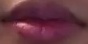

In [ ]:
from PIL import Image
Image.open(('data/cropped/000001.jpg'))

In [ ]:
root_dir = "data/train_phone"
for _, r in df.iterrows():
    if not op.exists(f"{root_dir}/{r.phone}"):
        os.makedirs(f"{root_dir}/{r.phone}")
    shutil.copy(f"data/cropped/{r.image}", f"{root_dir}/{r.phone}/{r.image}")

In [ ]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=1),
    batch_tfms=aug_transforms()
)

In [ ]:
parent_label("data/tain_phone/none/000001.jpg")

In [ ]:
dls = fields.dataloaders("data/train_phone/")

In [ ]:
dls.vocab

['aa', 'ae', 'ah', 'ao', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'eh', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'none', 'ow', 'oy', 'p', 'r', 's', 'sh', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z', 'zh']

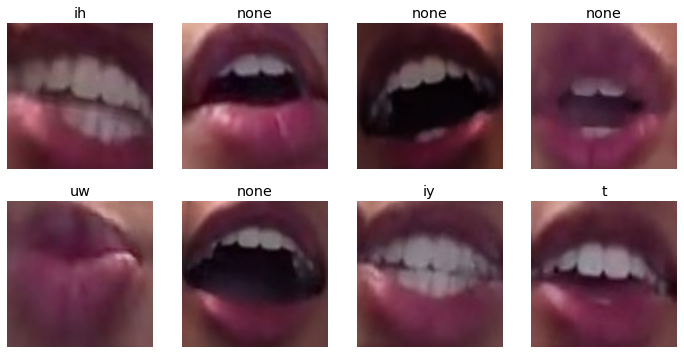

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

In [ ]:
learner = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0020892962347716093)

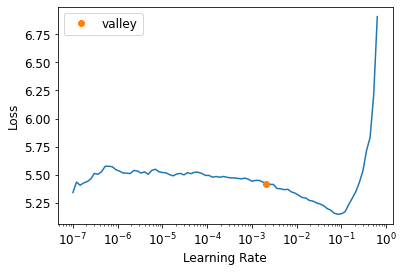

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(epochs=6, freeze_epochs=1, base_lr=0.0021)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.864425,2.724536,0.703441,0.296559,12:24


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.469998,2.423700,0.666338,0.333662,17:30
1,2.321015,2.291972,0.646020,0.353980,17:31
2,2.188901,2.159503,0.617310,0.382690,17:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.469998,2.423700,0.666338,0.333662,17:30
1,2.321015,2.291972,0.646020,0.353980,17:31
2,2.188901,2.159503,0.617310,0.382690,17:31
3,2.017969,2.068784,0.595093,0.404907,17:32
4,1.881958,1.978835,0.571738,0.428262,17:31
5,1.798404,1.968829,0.570788,0.429212,17:29


In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# **ARPAbet**

In [ ]:
!curl -s -O https://raw.githubusercontent.com/Alexir/CMUdict/master/cmudict-0.7b

In [ ]:
!head -1 cmudict-0.7b

;;; # CMUdict  --  Major Version: 0.07


In [ ]:
pronunciations = {}
for line in open("cmudict-0.7b", 'r', errors='replace').readlines():
  line = line.strip()
  if line.startswith(";"): continue
  word, phones = line.split("  ")
  word = word.rstrip("(0123)").lower()
  if word not in pronunciations:
    pronunciations[word] = []
  pronunciations[word].append(phones)

In [ ]:
pronunciations["suspicious"]

['S AH0 S P IH1 SH AH0 S']